In [1]:
import numpy as np
import scipy as sp
import pickle as pkl
import networkx as nx
from py2neo import Graph
import py2neo
import pandas as pd
import nxviz as nv
import matplotlib.pyplot as plt
from stellargraph import StellarGraph
from sklearn import metrics


%matplotlib inline

broker_nodes = pkl.load(open( "broker_nodes_brunosept.pkl", "rb" ))
cars_nodes = pkl.load(open( "cars_nodes_brunosept.pkl", "rb" ))
claims_nodes = pkl.load(open( "claims_nodes_brunosept.pkl", "rb" ))
policy_nodes = pkl.load(open( "policy_nodes_brunosept.pkl", "rb" ))
edges = pkl.load(open( "edges_brunosept.pkl", "rb" ))

labels = pd.DataFrame(pkl.load(open("Y", "rb")))
labels.rename(columns = {"y1": "Fraud", "y2":"Labelled"}, inplace = True)

HG = StellarGraph({"claim" : claims_nodes, "car" : cars_nodes, "policy" : policy_nodes, "broker" : broker_nodes}, edges)

HG_claims = HG.nodes("claim")
HG_cars = HG.nodes("car")
HG_sub = list(HG_claims)+ list(HG_cars)
adjmat_claim_car = HG.to_adjacency_matrix(HG_sub)[:len(HG_claims), len(HG_claims):]

HG_policies = HG.nodes("policy")
HG_sub = list(HG_cars)+list(HG_policies)
adjmat_car_policy = HG.to_adjacency_matrix(HG_sub)[:len(HG_cars), len(HG_cars):]

HG_brokers = HG.nodes("broker")
HG_sub = list(HG_policies) + list(HG_brokers)
adjmat_policy_broker = HG.to_adjacency_matrix(HG_sub)[:len(HG_policies), len(HG_policies):]

C = adjmat_claim_car
P = adjmat_car_policy
B = adjmat_policy_broker
CP = C @ P
CB = CP @ B

A_bipartite = sp.sparse.hstack((C, 
                                CP,
                                CB
                               )).tocsr()


nRows = A_bipartite.shape[0]
edges = {"source":[], "target":[], "weight":[]}

from tqdm.notebook import tqdm
for i in tqdm(range(nRows)):
    nonzeroIndices = A_bipartite[i, :].nonzero()
    for j in nonzeroIndices[1]:
        w = A_bipartite[i,j]
        edges["source"].append(i)
        edges["target"].append(j)
        edges["weight"].append(w)
        
df_edges = pd.DataFrame(edges)

party_index = np.concatenate((np.array(cars_nodes.index), np.array(policy_nodes.index), np.array(broker_nodes.index)
                             ))
pd_party_index = pd.DataFrame(party_index)
pd_party_index.columns = ["party"]
pd_party_index["party_num"] = range(len(party_index))

pd_claim_index = pd.DataFrame(claims_nodes.index)
pd_claim_index.columns = ["claim"]
pd_claim_index["claim_num"] = range(len(claims_nodes.index))

pd_merged = pd_claim_index.merge(df_edges.merge(pd_party_index, how = "left", left_on = "target", right_on = "party_num"), left_on = "claim_num", right_on = "source")
pd_merged = pd_merged[["claim", "party", "weight"]]
pd_merged.columns = ["source", "target", "weight"]

all_claims = pd.DataFrame(pd_claim_index['claim'])
all_claims.columns = ["ID"]
all_claims = all_claims.set_index("ID")

all_parties = pd.DataFrame(pd_party_index['party'])
all_parties.columns = ["ID"]
all_parties = all_parties.set_index("ID")

HG_bipartite = StellarGraph({"claim": all_claims, "party":all_parties},edges = pd_merged[["source", "target"]])

Nx_bipartite = HG_bipartite.to_networkx()

labels = pd.DataFrame(pkl.load(open("Y", "rb")))
labels.rename(columns = {"y1": "Fraud", "y2":"Labelled"}, inplace = True)

C:\Users\bruno\anaconda3\lib\site-packages\nxviz\__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.0 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.0, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


  0%|          | 0/396146 [00:00<?, ?it/s]

In [2]:
degrees = Nx_bipartite.degree
deg_cl = [degrees[cl] for cl in list(all_claims.index)]

In [3]:
deg_cl_sort = np.sort(deg_cl)
deg_cl_unique = np.unique(deg_cl)

In [4]:
N = len(deg_cl)
x = deg_cl_unique
px = []
for cl in x:
    p = np.mean(deg_cl_sort== cl)
    px.append(p)
    

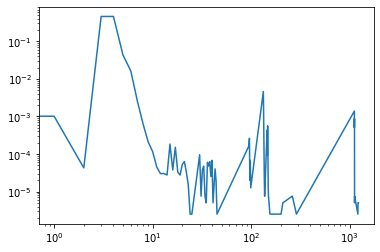

In [5]:
plt.plot(x, px)
plt.xscale('log')
plt.yscale('log')